In [742]:

# Импортируем необходимые библиотеки

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from scipy import stats


In [743]:
# Для более приятного визуального восприятия скроем предупреждения

import warnings
warnings.filterwarnings('ignore')

In [744]:
# Загружаем наши данные.
# Выведем ознакомительную информацию о таблице и посмотрим на первые строки

data = pd.read_csv('ds_salaries.csv')
data.head()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В наших данных 607 записей и 11 информативных столбцов. Двенадцатый столбец 'Unnamed: 0' содержит информацию о порядковом индексе записи. Так как для нашего DataFrame индексы сформировались автоматически, удалим столбец 'Unnamed' для лучшего визуального воспприятия. 
Пропусков в данных нет.
Проверим датасет на отсутствие дубликатов.

In [745]:
dupls = data[data.duplicated()]
print('Количество дубликатов = {}'.format(dupls.shape[0]))

data = data.drop('Unnamed: 0', axis = 1)

Количество дубликатов = 0


Дубликатов в данных не обнаружено.
Посмотрим на распредление признака заработной платы в USD.

### Распределение заработной платы

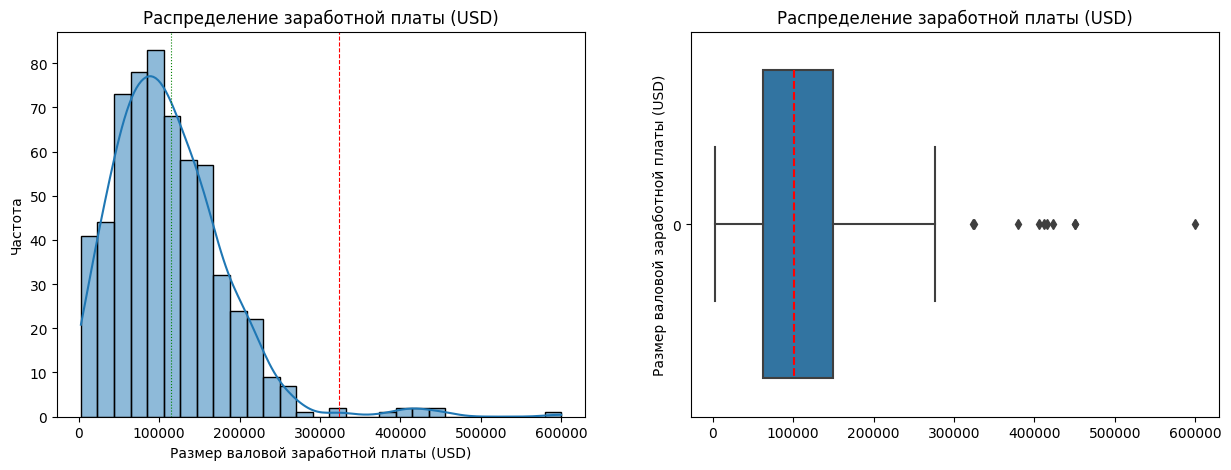

In [746]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data['salary_in_usd'], kde = True, ax=axes[0])
axes[0].set(xlabel = 'Размер валовой заработной платы (USD)', ylabel = 'Частота')
axes[0].set_title('Распределение заработной платы (USD)')
axes[0].axvline(data['salary'].mean(), color='red', linestyle='--', linewidth=0.8)
axes[0].axvline(data['salary'].median(), color='green', linestyle=':', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax = axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel = 'Размер валовой заработной платы (USD)')
axes[1].set_title('Распределение заработной платы (USD)')

plt.show()

In [747]:
# Посмотрим на описательную статистику признака

data['salary_in_usd'].describe().round(2).to_frame()

,salary_in_usd
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


На гистограмме распределения заработной платы мы можем увидеть, что есть ярко выраженная правосторонняя ассиметрия, медиана отличается от среднего, что указывает нам на отличие нашего распределения от нормального, в котором среднее = медиана.
На коробчатой диаргамме выбросы подсвечены еще сильнее: есть по крайней мере около 8 наблюдений, сильно отличающихся от верхнего квартиля. 
Описательная статистика так же дает нам полезные для оценки распреления зп показатели: минимальное (2 859 USD), максимальное зачение(600 000). Оба этих показателя вызывают сомнения в корректности введенных данных. 
Посмотрим на выбросы, используя метод межквартильного размаха. 

### Определяем выбросы методом Тьюкки

In [748]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    return outliers

outliers = outliers_iqr(data, 'salary_in_usd')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')

outliers.sort_values(by = 'salary_in_usd', ascending=False)

Число выбросов по методу Тьюки: 10


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
252,2021,EX,FT,Principal Data Engineer,600000,USD,600000,US,100,US,L
33,2020,MI,FT,Research Scientist,450000,USD,450000,US,0,US,M
97,2021,MI,FT,Financial Data Analyst,450000,USD,450000,US,100,US,L
157,2021,MI,FT,Applied Machine Learning Scientist,423000,USD,423000,US,50,US,L
225,2021,EX,CT,Principal Data Scientist,416000,USD,416000,US,100,US,S
63,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
523,2022,SE,FT,Data Analytics Lead,405000,USD,405000,US,100,US,L
519,2022,SE,FT,Applied Data Scientist,380000,USD,380000,US,100,US,L
25,2020,EX,FT,Director of Data Science,325000,USD,325000,US,100,US,L
482,2022,EX,FT,Data Engineer,324000,USD,324000,US,100,US,M


Просматривая информацию о выбросах (10 записей), полученных методом Тьюкки, можно отметить общее в этих данных: 
- все зарплаты получены в USD;
- компании распологаются на территории США;
- тип трудоустройства за исключением одной записи - полный рабочий день (говоря о записи-исключении, надо так же отметить, что "контракт" никак не исключает возможность полного рабочего дня);

Отличны друг от друга эти случаи размером компаний и опытом работников.
Логично предположить, что начинающий специалист по машинному обучению или анализу данных, с малой долей вероятности может получать бошльше директора в области Data Science. Эти записи определенно являются вывбросами ( data.iloc[[33, 97, 157]] ).
Для того, чтобы убедиться в том, что остальные данные так же являются выбросами (есть сомнения, так как записи с высокими зп для позиции сеньеров и директоров), посмотрим на статистику по зп для этих позиций.

In [749]:
data[data['experience_level'] == 'EX']['salary_in_usd'].sort_values(ascending=False).describe()
data[data['experience_level'] == 'SE']['salary_in_usd'].sort_values(ascending=False).describe()

count       280.000000
mean     138617.292857
std       57691.978337
min       18907.000000
25%      100000.000000
50%      135500.000000
75%      170000.000000
max      412000.000000
Name: salary_in_usd, dtype: float64

Для позиции 'SE' уровень верхнего квартиля - 170 000 USD.
Для позиции 'EX' верхний квартиль равен 233 750 USD.

В таком случае, согласимся с теорией межквартильного размаха и удалим выбросы из данных.

In [750]:
cleaned_data = data.drop(outliers.index, axis = 0)

# 1. Выясним какие факторы влияют на зарплату специалиста Data Scientist

Произведем кодирование признаков, чтобы с помощью функций для выявления корреляции понять есть ли зависимость между признаками.

Для порядковых признаков 'experience_level', 'remote_ratio', 'company_size' я буду исполmзовать ORDINAL ENCODING. 

Однократное кодирование я использую для номинального признаков с небольшим количеством уникальных значений: 'employment_type'.

Для признаков 'salary_currency', 'employee_residence', 'company_location' использую бинарное кодирование.

Для кодирования признака 'job_title' создадим столбец 'job_name', который получим с помощью функции get_title_top. Данный столбец преобразует исходный признак и относит название должности к одной из трех групп: 'Scientist', 'Engineer', 'Analyst'.
Затем применим однократное кодирование (OneHot Encoding).

Удалим признак "salary", так как связь с ним может быть выявленна некорректно по причине того, что уровень зп, исчесляемый в разных валютах, сравнивать недопустимо.

In [751]:
exp_level_encoder = ce.OrdinalEncoder(mapping = [{
    'col': 'experience_level',
    'mapping': {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
}])
experience_bin = exp_level_encoder.fit_transform(cleaned_data[['experience_level']])
# cleaned_data = pd.concat([cleaned_data, experience_bin], axis = 1)


encoder_employment_type = ce.OneHotEncoder(cols = ['employment_type'], use_cat_names=True)
employment_type_bin = encoder_employment_type.fit_transform(cleaned_data['employment_type'])
# cleaned_data = pd.concat([cleaned_data, employment_type_bin], axis = 1)


currency_bin_encoder = ce.BinaryEncoder(cols=['salary_currency']) 
currency_bin = currency_bin_encoder.fit_transform(cleaned_data['salary_currency'])
# cleaned_data = pd.concat([cleaned_data, currency_bin], axis=1)


employee_bin_encoder = ce.BinaryEncoder(cols=['employee_residence']) 
employee_bin = employee_bin_encoder.fit_transform(cleaned_data['employee_residence'])
# cleaned_data = pd.concat([cleaned_data, employee_bin], axis=1)


remote_ratio_encoder = ce.OrdinalEncoder(mapping = [{
    'col': 'remote_ratio',
    'mapping': {0: 1, 50: 2, 100: 3}
}])
remote_ratio_bin = remote_ratio_encoder.fit_transform(cleaned_data[['remote_ratio']])
# cleaned_data = pd.concat([cleaned_data, remote_ratio_bin], axis = 1)


company_location_encoder = ce.BinaryEncoder(cols=['company_location']) 
company_location_bin = company_location_encoder.fit_transform(cleaned_data['company_location'])
# cleaned_data = pd.concat([cleaned_data, company_location_bin], axis=1)


company_size_encoder = ce.OrdinalEncoder(mapping = [{
    'col': 'company_size',
    'mapping': {'S': 1, 'M': 2, 'L': 3}
}])
company_size_bin = company_size_encoder.fit_transform(cleaned_data[['company_size']])
# cleaned_data = pd.concat([cleaned_data, company_size_bin], axis = 1)


cleaned_data = cleaned_data.drop('salary', axis = 1)

In [752]:
def get_title_top(feature):
    scientist_list = ['Scientist', 'Science']
    engineer_list = ['Engineer', 'Architect', 'Engineering']
    analyst_list = ['Analyst', 'Analytics']
    feature = feature.split(' ')
    for elem in feature:
        if elem in scientist_list:
            return 'Scientist'
        if elem in engineer_list:
            return 'Engineer'
        if elem in analyst_list:
            return 'Analyst'



cleaned_data['job_name'] = cleaned_data['job_title'].apply(get_title_top)
cleaned_data.groupby('job_name')['employment_type'].count().sort_values(ascending=False)


job_name_encoder = ce.OneHotEncoder(cols = ['job_name'], use_cat_names=True)
job_name_bin = job_name_encoder.fit_transform(cleaned_data['job_name'])
# cleaned_data = pd.concat([cleaned_data, job_name_bin], axis = 1)

In [771]:
# feature_data = pd.DataFrame()
# feature_data['work_year'] = cleaned_data['work_year']
# feature_data = pd.concat([feature_data, experience_bin], axis = 1)
# feature_data = pd.concat([feature_data, employment_type_bin], axis = 1)
# feature_data = pd.concat([feature_data, currency_bin], axis = 1)
# feature_data = pd.concat([feature_data, employee_bin], axis = 1)
# feature_data['salary_in_usd'] = cleaned_data['salary_in_usd']
# feature_data = pd.concat([feature_data, remote_ratio_bin], axis = 1)
# feature_data = pd.concat([feature_data, company_location_bin], axis = 1)
# feature_data = pd.concat([feature_data, company_size_bin], axis = 1)
# feature_data = pd.concat([feature_data, job_name_bin], axis = 1)

feature_data
# cleaned_data

,work_year,experience_level,employment_type_FT,employment_type_CT,employment_type_PT,employment_type_FL,salary_currency_0,salary_currency_1,salary_currency_2,salary_currency_3,...,company_location_1,company_location_2,company_location_3,company_location_4,company_location_5,company_size,job_name_Scientist,job_name_Engineer,job_name_Analyst,job_name_nan
0,2020,2,1,0,0,0,0,0,0,0,...,0,0,0,0,1,3,1,0,0,0
1,2020,3,1,0,0,0,0,0,0,1,...,0,0,0,1,0,1,1,0,0,0
2,2020,3,1,0,0,0,0,0,0,1,...,0,0,0,1,1,2,0,1,0,0
3,2020,2,1,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
4,2020,3,1,0,0,0,0,0,0,1,...,0,0,1,0,1,3,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,3,1,0,0,0,0,0,0,1,...,0,0,1,0,1,2,0,1,0,0
603,2022,3,1,0,0,0,0,0,0,1,...,0,0,1,0,1,2,0,1,0,0
604,2022,3,1,0,0,0,0,0,0,1,...,0,0,1,0,1,2,0,0,1,0
605,2022,3,1,0,0,0,0,0,0,1,...,0,0,1,0,1,2,0,0,1,0


In [754]:
# Посмотрим на матрицу корреляции. Оставим признаки, в которых прослеживается хотя бы слабая взаимосвязь

data_corr = pd.DataFrame(cleaned_data.corr(numeric_only = True))
data_corr[(data_corr > 0.29) | (data_corr < -0.29)]['salary_in_usd'].dropna().sort_values(ascending=False)

salary_in_usd    1.0
Name: salary_in_usd, dtype: float64

Из матрицы корреляции можно сделать вывод о том, что заработная плата в большей степени зависит от занимаемой должность (в контексте опыта работы, то есть признака "experience_level").
Так же прослеживается слабая взаимосвязь уровня з/п с такими признаками, как: географический признак("employee_residence", "company_location"), валюта, в которой была выплачена зп "salary_currency".

# 2. Ответы на ключевые вопросы HR-агентства

**2.1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?**

<AxesSubplot: xlabel='work_year', ylabel='salary_in_usd'>

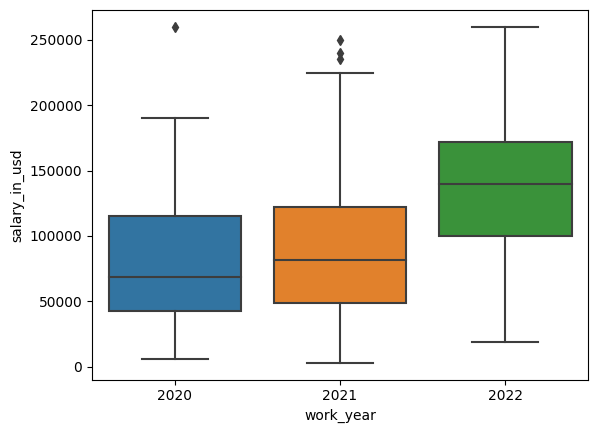

In [755]:
# Для ответа на этот вопрос выберем данные специалистов, которые работали в позиции Data Scientist, визуализируем группировку.

data_scientist = cleaned_data[cleaned_data['job_name'] == 'Scientist']
sns.boxplot(data_scientist, x = 'work_year', y = 'salary_in_usd')

# Из графика следует, что заработная плата специалистов по Data Science росла с каждым годом.
# Проверим эту теорию c помощью статистического теста.

In [756]:
alpha = 0.05

# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


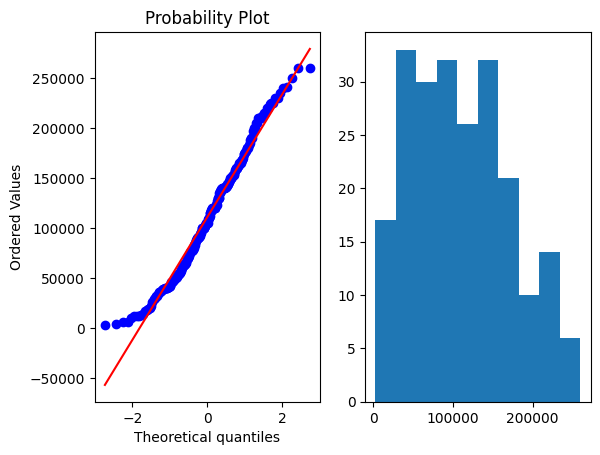

In [757]:
# Для выбора статистического теста выясним, является ли распределение зп для интересующей нас группы нормальным. Построим pp-plot и гистограмму.

plt.subplot(1,2,1)
stats.probplot(data_scientist['salary_in_usd'], plot = plt)
plt.subplot(1,2,2)
plt.hist(data_scientist['salary_in_usd'])

# Как мы можем увидеть на графиках, распределение не является нормальным.
# Подтвердим наши наблюдения тестом Шапиро-Уилка:

_, p = stats.shapiro(data_scientist['salary_in_usd'])
decision_normality(p)
    
# Проведенный статистический тест подтвердил ненормальность распределения данных.

Для проверки нашей теории о росте зп для специалистов DS, воспользуемся u-критерием Манна - Уитни.
Так как требуется подтвердит рост в каждом новом году, сначала сравним 2020 и 2021 год, а затем 2021 и 2022.

**Сформулируем гипотезы:**

*Нулевая гипотеза* ($H_0$): з/п в 2020 году ($μ_1$) больше или равна з/п в 2021 году ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): з/п в 2020 году ($μ_1$) статистически больше, чем больше или равна з/п в 2021 году ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

In [758]:
year2020 = data_scientist.loc[data_scientist['work_year'] == 2020, 'salary_in_usd']
year2021 = data_scientist.loc[data_scientist['work_year'] == 2021, 'salary_in_usd']
year2022 = data_scientist.loc[data_scientist['work_year'] == 2022, 'salary_in_usd']

# Статистически проверим рост зп в 2021 году по сравнению с 2020 годом
_, p = stats.mannwhitneyu(year2020, year2021, alternative='less')
decision_hypothesis(p)

p-value = 0.368
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Тест не подтвердил наших предположений о том, что зарплата специалистов DS выросла в 2021 году, по сравнению с предыдущим годом.
Проверим нашу теорию относительно 2021 и 2022 года (на коробчатой диаграмме разница между ними выражена сильнее).

**Сформулируем гипотезы:**

*Нулевая гипотеза* ($H_0$): з/п для специалистов DS в 2021 году ($μ_1$) больше или равна з/п DS спеиалистов в 2022 году ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): з/п для специалистов DS в 2021 году ($μ_1$) статистически больше, чем з/п DS специалистов в 2022 году ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

In [759]:
_, p = stats.mannwhitneyu(year2021, year2022, alternative='less')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Ответ 2.1:
Результаты теста говорят о том, что наше предположение верно: зп для специалистов в области Data Science выросло в 2022 году (по сравнению с двумя предыдущими годами).**

**2.2.Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?**

,count,mean,std,min,25%,50%,75%,max
job_name,,,,,,,,
Engineer,122.0,125564.0,55653.0,10000.0,78894.0,120000.0,163767.0,266400.0
Scientist,100.0,137562.0,53853.0,18442.0,100000.0,140000.0,171500.0,260000.0


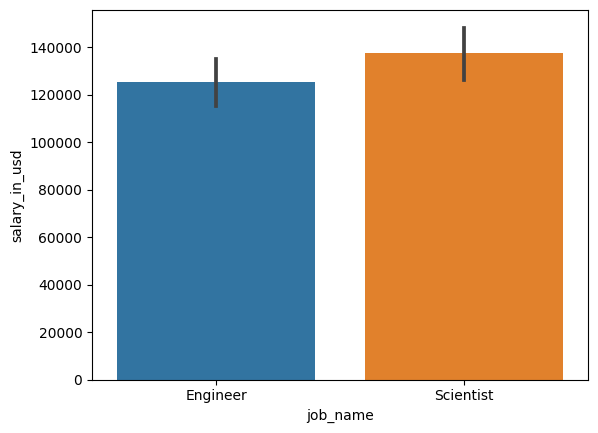

In [760]:
DS_Engineer = cleaned_data[((cleaned_data['job_name'] == 'Scientist') | (cleaned_data['job_name'] == 'Engineer')) & (cleaned_data['work_year'] == 2022)]
sns.barplot(DS_Engineer, x = 'job_name', y = 'salary_in_usd')

round(DS_Engineer.groupby('job_name')['salary_in_usd'].describe())

Из графика и описательной статистики можно с делать вывод о том, что у Data Scientist-ов средняя заработная плата выше, чем у Data Ingineer-ов. Минимальный порог зп так же выше у представителей первой группы (DS) - 18 442 USD в противовес 10 000 USD. 
Проверим сделанные выводы статистическим тестом Манна - Уитни.

**Сформулируем гипотезы:**

*Нулевая гипотеза* ($H_0$): з/п у дата инженеров в 2022 году ($μ_1$) больше или равна з/п дата саентистов в 2022 году ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): з/п у дата инженеров в 2022 году ($μ_1$) статистически меньше, чем з/п дата саентистов в 2022 году ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

In [761]:
Engineer2022 = DS_Engineer[DS_Engineer['job_name'] == 'Engineer']
Scientist2022 = DS_Engineer[DS_Engineer['job_name'] == 'Scientist']
_, p = stats.mannwhitneyu(Engineer2022['salary_in_usd'], Scientist2022['salary_in_usd'], alternative='less')
decision_hypothesis(p)

p-value = 0.038
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Ответ 2.2 Результат статистического теста не заставляет сомневаться в нашей теории о том, что зарплатов специалистов по Data Science в 2022 году выше зарплат для Data Engineer-ов в 2022 году.**

**2.3 Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?**

<AxesSubplot: xlabel='company_size', ylabel='salary_in_usd'>

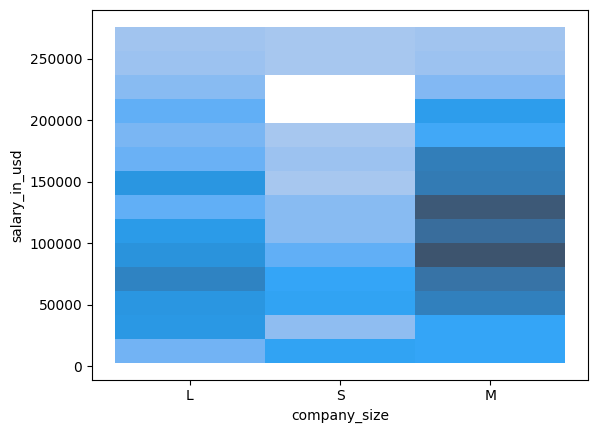

In [762]:
# cleaned_data.groupby('salary_in_usd')['company_size'].mean()

sns.histplot(cleaned_data, x = 'company_size', y = 'salary_in_usd')

In [763]:
cleaned_data

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_name
0,2020,MI,FT,Data Scientist,EUR,79833,DE,0,DE,L,Scientist
1,2020,SE,FT,Machine Learning Scientist,USD,260000,JP,0,JP,S,Scientist
2,2020,SE,FT,Big Data Engineer,GBP,109024,GB,50,GB,M,Engineer
3,2020,MI,FT,Product Data Analyst,USD,20000,HN,0,HN,S,Analyst
4,2020,SE,FT,Machine Learning Engineer,USD,150000,US,50,US,L,Engineer
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,USD,154000,US,100,US,M,Engineer
603,2022,SE,FT,Data Engineer,USD,126000,US,100,US,M,Engineer
604,2022,SE,FT,Data Analyst,USD,129000,US,0,US,M,Analyst
605,2022,SE,FT,Data Analyst,USD,150000,US,100,US,M,Analyst
